In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import datetime
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

def generate_default_plot_env():
    sns.set(font_scale=1.4, style="whitegrid")
    matplotlib.rcParams['pdf.fonttype'] = 42
    matplotlib.rcParams['ps.fonttype'] = 42
    matplotlib.rc('font', family='sans-serif') 
    matplotlib.rc('font', serif='Helvetica Neue') 
    matplotlib.rc('text', usetex='false') 
    matplotlib.rcParams.update({'font.size': 22})
    
    plt.rcParams['pdf.fonttype'] = 42
    plt.rcParams['ps.fonttype'] = 42
    plt.rc('font', family='sans-serif') 
    plt.rc('font', serif='Helvetica Neue') 
    plt.rc('text', usetex='false') 
    plt.rcParams.update({'font.size': 22})

# pd.set_option('display.height', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 200)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
generate_default_plot_env()

In [4]:
ws_diff_movers_df = pd.read_csv('../data/ws_diff_movers_popstats.csv')
all_df = pd.read_csv('../data/all_popstats.csv')
mover_df = pd.read_csv('../data/mover_popstats.csv')
actual_NM_data_df = pd.read_csv('../data/non_movers_popstats.csv')

In [5]:
male_ws_diff_movers_df = ws_diff_movers_df[ws_diff_movers_df['user_profile_gender'] == 'male']
male_all_df = all_df[all_df['user_profile_gender'] == 'male']
male_movers_df = mover_df[mover_df['user_profile_gender'] == 'male']
male_non_movers_df = actual_NM_data_df[actual_NM_data_df["user_profile_gender"] == "male"]

In [6]:
female_ws_diff_movers_df = ws_diff_movers_df[ws_diff_movers_df['user_profile_gender'] == 'female']
female_all_df = all_df[all_df['user_profile_gender'] == 'female']
female_movers_df = mover_df[mover_df['user_profile_gender'] == 'female']
female_non_movers_df = actual_NM_data_df[actual_NM_data_df["user_profile_gender"] == "female"]

In [21]:
def plot_pop_comparison(col, xlabel, bins, gender, ylabel='Fraction of Population',
                        return_combined_df=False):
    if gender == 'male':
        NM_data_df = male_all_df
        actual_NM_data_df = male_non_movers_df
        M_data_df = male_movers_df
    elif gender == 'female':
        NM_data_df = female_all_df
        actual_NM_data_df = female_non_movers_df
        M_data_df = female_movers_df
    
    print('Avg', gender, 'Mover', col, 'is:', M_data_df[col].mean())
    print('Avg', gender, 'Non-Mover', col, 'is:', actual_NM_data_df[col].mean())
    
    bin_col = col + '_bin'
    actual_NM_data_df[bin_col] = pd.cut(actual_NM_data_df[col], bins=bins, right=False)
    NM_data_df[bin_col] = pd.cut(NM_data_df[col], bins=bins, right=False)
    M_data_df[bin_col] = pd.cut(M_data_df[col], bins=bins, right=False)

    actual_NM_counts = actual_NM_data_df.groupby(bin_col).count().reset_index()
    non_movers_counts = NM_data_df.groupby(bin_col).count().reset_index()
    movers_counts = M_data_df.groupby(bin_col).count().reset_index()

    actual_NM_counts['fraction'] = actual_NM_counts[col] / actual_NM_counts[col].sum()
    non_movers_counts['fraction'] = non_movers_counts[col] / non_movers_counts[col].sum()
    movers_counts['fraction'] = movers_counts[col] / movers_counts[col].sum()

    actual_NM_counts['User Type'] = 'Our Data (Non-Movers)'
    non_movers_counts['User Type'] = 'Our Data (All)'
    movers_counts['User Type'] = 'Our Data (Movers)'

    combined_df = pd.concat([non_movers_counts[[bin_col, 'fraction', 'User Type']], 
                             movers_counts[[bin_col, 'fraction', 'User Type']]],
                            ignore_index=True)

    if return_combined_df:
        combined_df = pd.concat([actual_NM_counts[[bin_col, 'fraction', 'User Type']], 
                                 movers_counts[[bin_col, 'fraction', 'User Type']]],
                                 ignore_index=True)
        return combined_df
    
    sns.barplot(data=combined_df, y='fraction', x=bin_col, hue='User Type', ax=ax,
                palette=["#de1b1b", "#f4a2a2"] if gender == 'female' else ["#1f78b4", "#a7d3f0"]);

    xtick_labels = list()
    if col == 'json_steps':
        for age_bin in pd.unique(combined_df[bin_col]):
            left, right = str(age_bin).split(', ')
            left, right = left[1:], right[:-1]
            if right == 'inf':
                xtick_labels.append(str(int(float(left))/1000) + '+')
            else:
                xtick_labels.append(str(int(float(left))/1000))
    
    elif col == 'user_profile_bmi':
        xtick_labels = ['Underweight', 'Normal', 'Overweight', 'Obese']
    
    else:
        for age_bin in pd.unique(combined_df[bin_col]):
            left, right = str(age_bin).split(', ')
            left, right = left[1:], right[:-1]
            if right == 'inf':
                xtick_labels.append(str(int(float(left))) + '+')
            else:
                xtick_labels.append(str(int(float(left))) + ' to ' + str(int(float(right)) - 1))

    ax.set_xticklabels(xtick_labels)
    plt.xticks(rotation=90)
    ax.grid(False)

    if gender == 'male':
        plt.title('Males');
    elif gender == 'female':
        plt.title('Females');
    
    plt.ylabel(ylabel);
    plt.xlabel(xlabel);
    leg = plt.legend()

In [22]:
pd.options.mode.chained_assignment = None  # default='warn'

In [27]:
def plot_movers_pop_comparison(col, xlabel, bins, gender, ylabel='Fraction of Population',
                               return_combined_df=False):
    if gender == 'male':
        M_data_df = male_ws_diff_movers_df
    elif gender == 'female':
        M_data_df = female_ws_diff_movers_df
        
    higher_df = M_data_df[M_data_df['ws_diff_class'] == 'Higher']
    lower_df = M_data_df[M_data_df['ws_diff_class'] == 'Lower']
    similar_df = M_data_df[M_data_df['ws_diff_class'] == 'Similar']
    
    print('Avg', gender, 'Mover to Higher Walkabaility', col, 'is:', higher_df[col].mean())
    print('Avg', gender, 'Mover to Similar Walkabaility', col, 'is:', similar_df[col].mean())
    print('Avg', gender, 'Mover to Lower Walkabaility', col, 'is:', lower_df[col].mean())
    
    bin_col = col + '_bin'
    for df in [higher_df, lower_df, similar_df]:
        df[bin_col] = pd.cut(df[col], bins=bins, right=False)

    higher_counts = higher_df.groupby(bin_col).count().reset_index()
    similar_counts = similar_df.groupby(bin_col).count().reset_index()
    lower_counts = lower_df.groupby(bin_col).count().reset_index()

    for df in [higher_counts, similar_counts, lower_counts]:
        df['fraction'] = df[col] / df[col].sum()
        
    # Post-relocation walkability compared to pre-relocation.
    higher_counts['User Type'] = 'Higher'
    similar_counts['User Type'] = 'Similar'
    lower_counts['User Type'] = 'Lower'

    combined_df = pd.concat([higher_counts[[bin_col, 'fraction', 'User Type']],
                             similar_counts[[bin_col, 'fraction', 'User Type']],
                             lower_counts[[bin_col, 'fraction', 'User Type']]],
                            ignore_index=True)

    if return_combined_df:
        return combined_df
    
    sns.barplot(data=combined_df, y='fraction', x=bin_col, hue='User Type', ax=ax,
                palette=["#520a0a", "#de1b1b", "#f4a2a2"] if gender == 'female' else ["#0e3550", "#1f78b4", "#a7d3f0"]);

    xtick_labels = list()
    if col == 'json_steps':
        for age_bin in pd.unique(combined_df[bin_col]):
            left, right = str(age_bin).split(', ')
            left, right = left[1:], right[:-1]
            if right == 'inf':
                xtick_labels.append(str(int(float(left))/1000) + '+')
            else:
                xtick_labels.append(str(int(float(left))/1000))
    
    elif col == 'user_profile_bmi':
        xtick_labels = ['Underweight', 'Normal', 'Overweight', 'Obese']
    
    else:
        for age_bin in pd.unique(combined_df[bin_col]):
            left, right = str(age_bin).split(', ')
            left, right = left[1:], right[:-1]
            if right == 'inf':
                xtick_labels.append(str(int(float(left))) + '+')
            else:
                xtick_labels.append(str(int(float(left))) + ' to ' + str(int(float(right)) - 1))

    ax.set_xticklabels(xtick_labels)
    plt.xticks(rotation=90)
    ax.grid(False)

    if gender == 'male':
        plt.title('Males');
    elif gender == 'female':
        plt.title('Females');
    
    plt.ylabel(ylabel);
    plt.xlabel(xlabel);
    leg = plt.legend()

#### Age

Avg male Mover user_profile_age is: 43.76033553025764
Avg male Non-Mover user_profile_age is: 37.91859973830235
Avg female Mover user_profile_age is: 38.50182260024302
Avg female Non-Mover user_profile_age is: 33.73862612997731


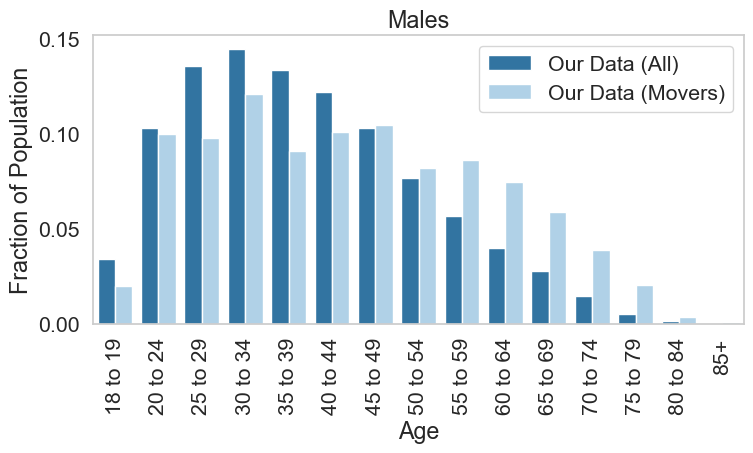

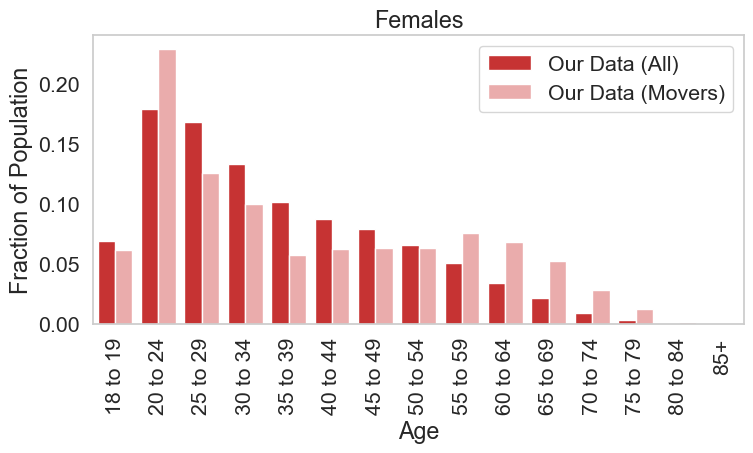

In [28]:
age_bins = [18] + list(range(20, 86, 5)) + [np.inf]

f, ax = plt.subplots(figsize=(8, 5))
plot_pop_comparison('user_profile_age', 'Age', age_bins, 'male')
plt.tight_layout()
plt.yticks(np.arange(0., 0.16, 0.05))
plt.savefig('../output/fig11a.pdf', dpi=300)

f, ax = plt.subplots(figsize=(8, 5))
plot_pop_comparison('user_profile_age', 'Age', age_bins, 'female')
plt.tight_layout()
plt.savefig('../output/fig11b.pdf', dpi=300)

Avg male Mover to Higher Walkabaility user_profile_age is: 44.38658777120315
Avg male Mover to Similar Walkabaility user_profile_age is: 43.72923076923077
Avg male Mover to Lower Walkabaility user_profile_age is: 44.96382978723404
Avg female Mover to Higher Walkabaility user_profile_age is: 39.034907597535934
Avg female Mover to Similar Walkabaility user_profile_age is: 38.26187961985217
Avg female Mover to Lower Walkabaility user_profile_age is: 38.29934924078091


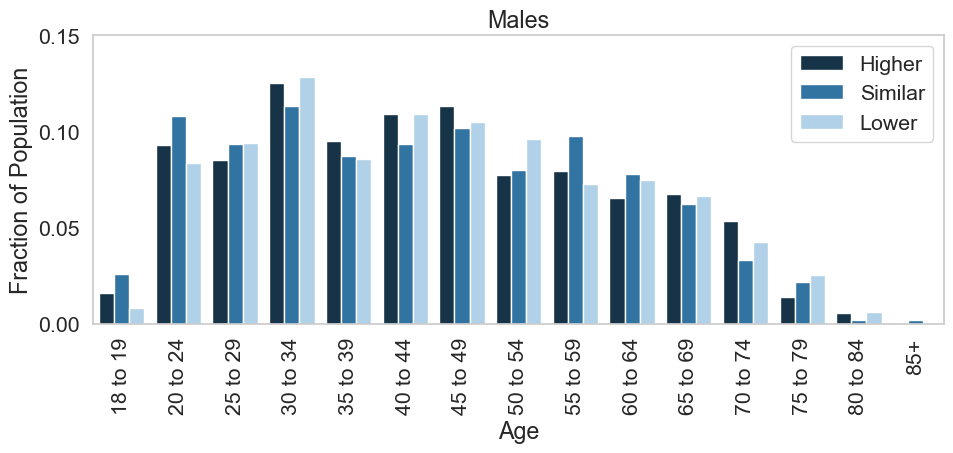

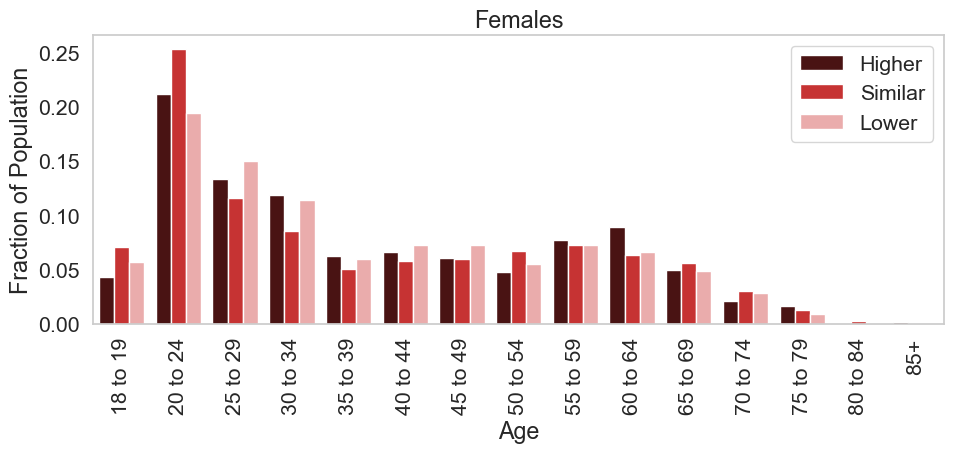

In [29]:
age_bins = [18] + list(range(20, 86, 5)) + [np.inf]

f, ax = plt.subplots(figsize=(10, 5))
plot_movers_pop_comparison('user_profile_age', 'Age', age_bins, 'male')
plt.tight_layout()
plt.yticks(np.arange(0., 0.16, 0.05))
plt.savefig('../output/fig12a.pdf', dpi=300)

f, ax = plt.subplots(figsize=(10, 5))
plot_movers_pop_comparison('user_profile_age', 'Age', age_bins, 'female')
plt.tight_layout()
plt.savefig('../output/fig12b.pdf', dpi=300)

#### BMI

In [32]:
bmi_bins = [0, 18.5, 25, 30, np.inf]

In [33]:
combined_df = plot_pop_comparison('user_profile_bmi', 'BMI', bmi_bins, 'male', return_combined_df=True)
combined_df

Avg male Mover user_profile_bmi is: 27.738821209799347
Avg male Non-Mover user_profile_bmi is: 26.968355532921166


,user_profile_bmi_bin,fraction,User Type
0,"[0.0, 18.5)",0.033244,Our Data (Non-Movers)
1,"[18.5, 25.0)",0.369045,Our Data (Non-Movers)
2,"[25.0, 30.0)",0.373468,Our Data (Non-Movers)
3,"[30.0, inf)",0.224243,Our Data (Non-Movers)
4,"[0.0, 18.5)",0.013049,Our Data (Movers)
5,"[18.5, 25.0)",0.306050,Our Data (Movers)
6,"[25.0, 30.0)",0.416370,Our Data (Movers)
7,"[30.0, inf)",0.264531,Our Data (Movers)


In [34]:
combined_df = plot_pop_comparison('user_profile_bmi', 'BMI', bmi_bins, 'female', return_combined_df=True)
combined_df

Avg female Mover user_profile_bmi is: 25.83240871125421
Avg female Non-Mover user_profile_bmi is: 25.90863229272378


,user_profile_bmi_bin,fraction,User Type
0,"[0.0, 18.5)",0.058230,Our Data (Non-Movers)
1,"[18.5, 25.0)",0.498285,Our Data (Non-Movers)
2,"[25.0, 30.0)",0.243370,Our Data (Non-Movers)
3,"[30.0, inf)",0.200115,Our Data (Non-Movers)
4,"[0.0, 18.5)",0.037417,Our Data (Movers)
5,"[18.5, 25.0)",0.506337,Our Data (Movers)
6,"[25.0, 30.0)",0.258298,Our Data (Movers)
7,"[30.0, inf)",0.197948,Our Data (Movers)


Avg male Mover user_profile_bmi is: 27.738821209799347
Avg male Non-Mover user_profile_bmi is: 26.968355532921166
Avg female Mover user_profile_bmi is: 25.83240871125421
Avg female Non-Mover user_profile_bmi is: 25.90863229272378


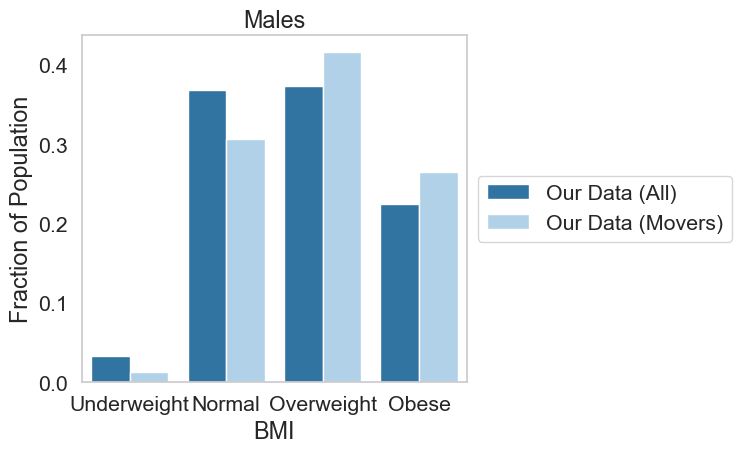

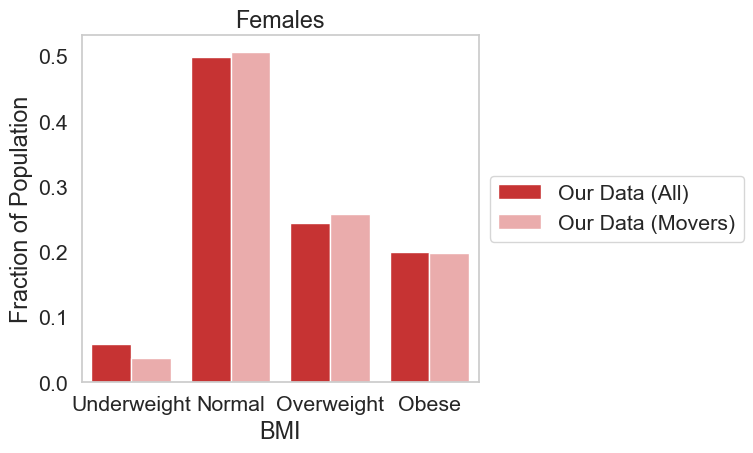

In [39]:
f, ax = plt.subplots(figsize=(8, 5))
plot_pop_comparison('user_profile_bmi', 'BMI', bmi_bins, 'male')
lgd = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig('../output/fig11c.pdf', dpi=300,
            bbox_extra_artists=(lgd,), bbox_inches='tight')

f, ax = plt.subplots(figsize=(8, 5))
plot_pop_comparison('user_profile_bmi', 'BMI', bmi_bins, 'female')
lgd = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig('../output/fig11d.pdf', dpi=300,
            bbox_extra_artists=(lgd,), bbox_inches='tight')

In [40]:
combined_df = plot_movers_pop_comparison('user_profile_bmi', 'BMI', bmi_bins, 'male', return_combined_df=True)
combined_df

Avg male Mover to Higher Walkabaility user_profile_bmi is: 27.7360194612332
Avg male Mover to Similar Walkabaility user_profile_bmi is: 27.539236931745446
Avg male Mover to Lower Walkabaility user_profile_bmi is: 27.709814854255292


,user_profile_bmi_bin,fraction,User Type
0,"[0.0, 18.5)",0.005825,Higher
1,"[18.5, 25.0)",0.300971,Higher
2,"[25.0, 30.0)",0.436893,Higher
3,"[30.0, inf)",0.256311,Higher
4,"[0.0, 18.5)",0.017206,Similar
5,"[18.5, 25.0)",0.309717,Similar
6,"[25.0, 30.0)",0.413968,Similar
7,"[30.0, inf)",0.259109,Similar
8,"[0.0, 18.5)",0.010593,Lower
9,"[18.5, 25.0)",0.324153,Lower


In [41]:
combined_df = plot_movers_pop_comparison('user_profile_bmi', 'BMI', bmi_bins, 'female', return_combined_df=True)
combined_df

Avg female Mover to Higher Walkabaility user_profile_bmi is: 25.79583313126817
Avg female Mover to Similar Walkabaility user_profile_bmi is: 25.811817412793317
Avg female Mover to Lower Walkabaility user_profile_bmi is: 25.766247559005578


,user_profile_bmi_bin,fraction,User Type
0,"[0.0, 18.5)",0.026694,Higher
1,"[18.5, 25.0)",0.507187,Higher
2,"[25.0, 30.0)",0.271047,Higher
3,"[30.0, inf)",0.195072,Higher
4,"[0.0, 18.5)",0.038825,Similar
5,"[18.5, 25.0)",0.512067,Similar
6,"[25.0, 30.0)",0.253935,Similar
7,"[30.0, inf)",0.195173,Similar
8,"[0.0, 18.5)",0.040773,Lower
9,"[18.5, 25.0)",0.497854,Lower


Avg male Mover to Higher Walkabaility user_profile_bmi is: 27.7360194612332
Avg male Mover to Similar Walkabaility user_profile_bmi is: 27.539236931745446
Avg male Mover to Lower Walkabaility user_profile_bmi is: 27.709814854255292
Avg female Mover to Higher Walkabaility user_profile_bmi is: 25.79583313126817
Avg female Mover to Similar Walkabaility user_profile_bmi is: 25.811817412793317
Avg female Mover to Lower Walkabaility user_profile_bmi is: 25.766247559005578


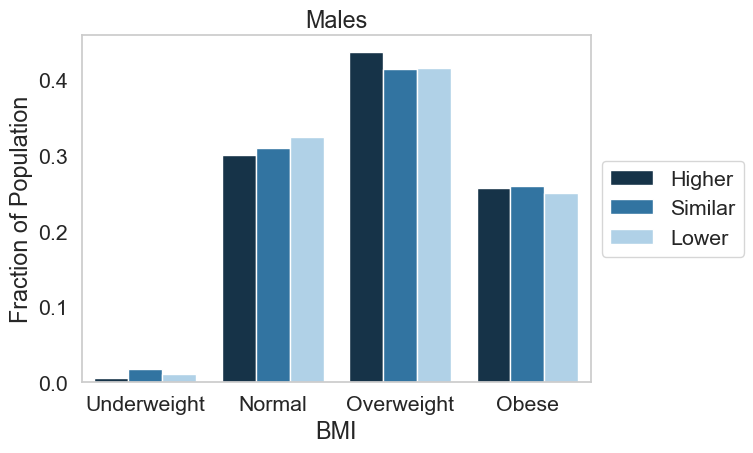

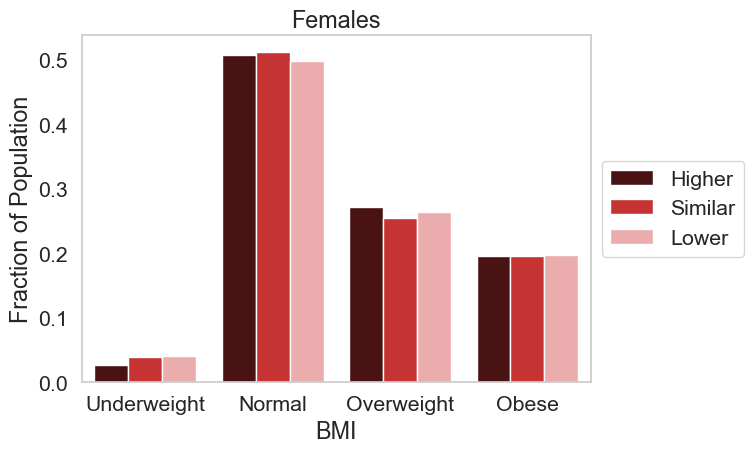

In [43]:
f, ax = plt.subplots(figsize=(8, 5))
plot_movers_pop_comparison('user_profile_bmi', 'BMI', bmi_bins, 'male')
lgd = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig('../output/fig12c.pdf', dpi=300,
            bbox_extra_artists=(lgd,), bbox_inches='tight')

f, ax = plt.subplots(figsize=(8, 5))
plot_movers_pop_comparison('user_profile_bmi', 'BMI', bmi_bins, 'female')
lgd = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig('../output/fig12d.pdf', dpi=300,
            bbox_extra_artists=(lgd,), bbox_inches='tight')

#### Avg. Physical Activity

Avg male Mover json_steps is: 6283.712745288963
Avg male Non-Mover json_steps is: 5824.723675802835
Avg female Mover json_steps is: 5278.814843236865
Avg female Non-Mover json_steps is: 4634.857099297945


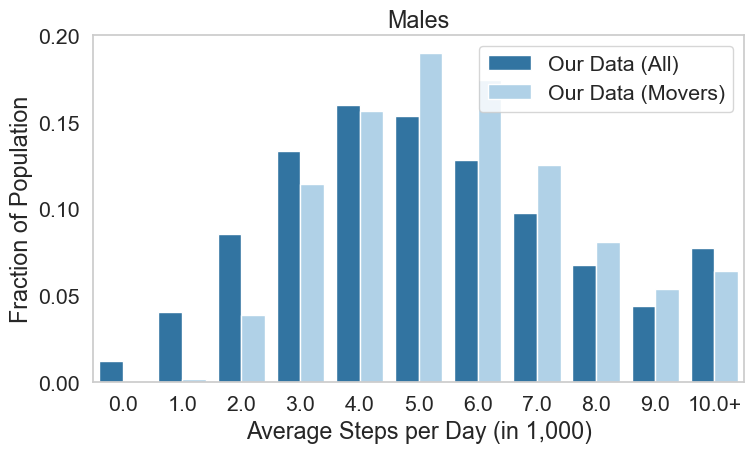

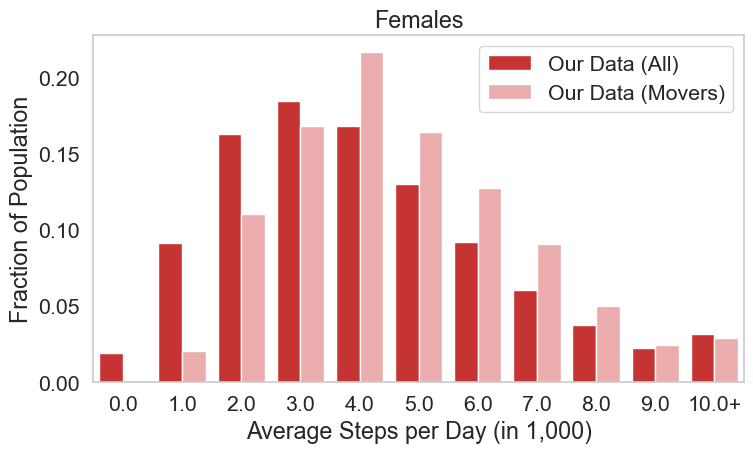

In [46]:
pa_bins = list(range(0, 10001, 1000)) + [np.inf]

f, ax = plt.subplots(figsize=(8, 5))
plot_pop_comparison('json_steps', 'Average Steps per Day (in 1,000)', pa_bins, 'male')
plt.xticks(rotation=0)
plt.yticks(np.arange(0., 0.21, 0.05))
plt.tight_layout()
plt.savefig('../output/fig11e.pdf', dpi=300)

f, ax = plt.subplots(figsize=(8, 5))
plot_pop_comparison('json_steps', 'Average Steps per Day (in 1,000)', pa_bins, 'female')
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig('../output/fig11f.pdf', dpi=300)

Avg male Mover to Higher Walkabaility json_steps is: 6256.8089851912155
Avg male Mover to Similar Walkabaility json_steps is: 6228.689185829568
Avg male Mover to Lower Walkabaility json_steps is: 6300.686308625027
Avg female Mover to Higher Walkabaility json_steps is: 5421.752849438934
Avg female Mover to Similar Walkabaility json_steps is: 5239.283365432714
Avg female Mover to Lower Walkabaility json_steps is: 5404.914968409924


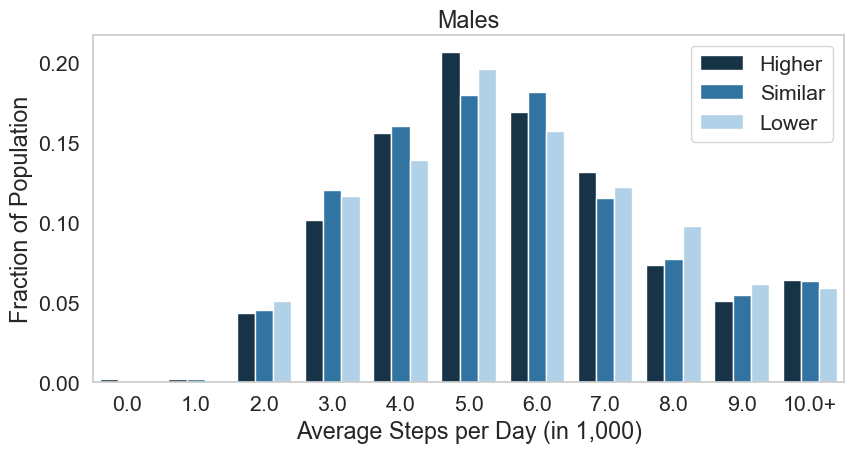

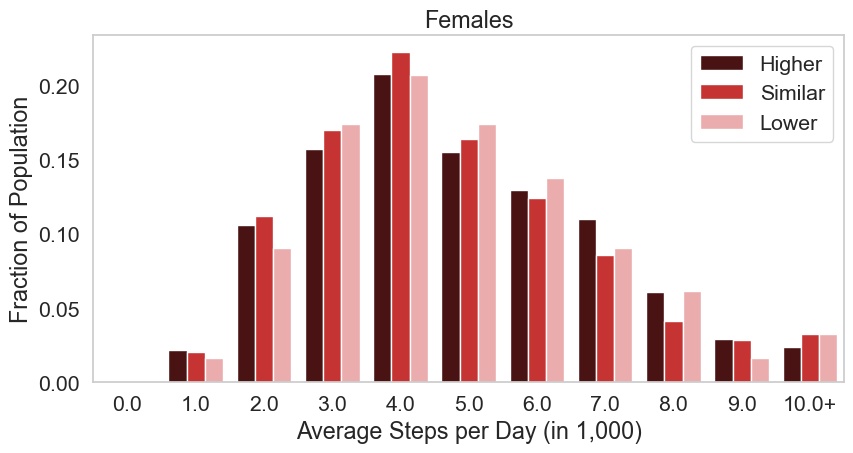

In [48]:
pa_bins = list(range(0, 10001, 1000)) + [np.inf]

f, ax = plt.subplots(figsize=(9, 5))
plot_movers_pop_comparison('json_steps', 'Average Steps per Day (in 1,000)', pa_bins, 'male')
plt.xticks(rotation=0)
plt.yticks(np.arange(0., 0.21, 0.05))
# ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig('../output/fig12e.pdf', dpi=300)

f, ax = plt.subplots(figsize=(9, 5))
plot_movers_pop_comparison('json_steps', 'Average Steps per Day (in 1,000)', pa_bins, 'female')
plt.xticks(rotation=0)
# ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig('../output/fig12f.pdf', dpi=300)